In [2]:
"""
This computes the delimiter score only for the CLS token.
"""

import pickle as pkl
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import os
import tokenization
import pandas as pd
import itertools

from matplotlib import colors
import matplotlib.pyplot as plt
num_sents = 20
num_layers, num_heads = 12, 12

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [3]:
def init(task_name):
    input_file='./texts/glue_data_{}_test_small.tsv'.format(task_name.upper())
    attn_file1='./pkl_dir/attention_weights_{}_small.pkl'.format(task_name)
    task_name=task_name
    
    # Read attention weights file.
    a = pkl.load(open(attn_file1, 'rb'))
    print("len of a {}".format(len(a)))
    print("shape of a {}".format(a[0].shape))
    
    # Read text file.
    f = open(input_file, 'r')
    f1 = f.readlines()
    f1 = f1[1:]   #Ignore the 1st row which has label.
    print("Total sentences in test set: {}".format(len(f1)))
    return f1, a

In [4]:
# p-val calculation
def ztest_own(pop1, th, n, alternate='smaller'):
    mu1, v = np.mean(pop1), np.std(pop1) 
    z = (mu1 - th)/(v/np.sqrt(n))
    df = n - 1
    rv = st.t(df)
    if alternate == 'larger':
        return rv.cdf(z)
    else:
        #print('here')
        return 1 - rv.cdf(z)
    
def get_pvalues(uniform_baseline_score, out_band):
    alt_pval = np.zeros([num_layers, num_heads])
    for l in range(num_layers):
            for h in range(num_heads):
                single_head_scores = []
                for s in range(num_sents):
                    single_head_scores.append(out_band[s][l,h])
                if len(uniform_baseline_score) != len(single_head_scores):
                    raise "Population lengths not same for p-value test."
                score = ztest_own(single_head_scores, uniform_baseline_score[0], num_sents)
                alt_pval[l,h] = score
    return alt_pval

In [5]:
def calc_noops_attn_score(a, f1, tokenizer, task_name):
    noops_score = np.zeros((num_sents, num_layers, num_heads))
    #print(num_sents)
    for i in range(num_sents):
        sent = f1[i].split('\t')
        if task_name in ['qqp', 'qnli']:
            sent_a = tokenizer.tokenize(sent[1])
            sent_b = tokenizer.tokenize(sent[2])
            final_sent = ['CLS '] + sent_a + [' SEP '] + sent_b + [' SEP']
        elif task_name == 'mrpc':
            sent_a = tokenizer.tokenize(sent[3])
            sent_b = tokenizer.tokenize(sent[4])
            final_sent = ['CLS '] + sent_a + [' SEP '] + sent_b + [' SEP']
        elif task_name == 'sst-2':
            sent_a = tokenizer.tokenize(sent[1])
            final_sent = ['CLS '] + sent_a + [' SEP']
        sent_len = len(final_sent)
        if sent_len > max_seq_len:
            sent_len = max_seq_len
            
        cls_idx = 0
        sep1_idx, sep2_idx = len(sent_a)+1, sent_len-1
        
        if task_name in ['sst-2']:
            sep2_idx = -1
    
        for l in range(num_layers):
            for h in range(num_heads):
                attn_per_head = a[i][l,h][:sent_len, :sent_len]
                sent_score = 0
                for token in range(sent_len):
                    avg_attn_over_all_toks = np.sum(attn_per_head[token, :])/sent_len
                    #if task_name in ['sst-2']: # Single setnece task.
                    token_score = (attn_per_head[token,cls_idx])
                    token_score = token_score/avg_attn_over_all_toks
                    sent_score+=token_score
                sent_score = sent_score/sent_len
                noops_score[i,l,h] = sent_score
    return noops_score

In [8]:
# visualize pval and score map.
def vis_and_save(out_band, task_name, output_dir):
    plt.figure(figsize=(8,6))
    g = sns.heatmap(np.average(out_band, axis=0), cmap='Blues', annot=True)   
    g.set(xticklabels=np.arange(12), yticklabels=np.arange(12))
    plt.xlabel('heads')
    plt.ylabel('layers')
    plt.title('Avg noops bias for {}'.format(task_name))
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    pkl.dump(out_band, open(output_dir + "all_heads_all_sents_noops_score_{}_subtype_CLS.pkl".format(task_name), 'wb'))

len of a 20
shape of a (12, 12, 128, 128)
Total sentences in test set: 20
len of a 20
shape of a (12, 12, 128, 128)
Total sentences in test set: 20
len of a 20
shape of a (12, 12, 128, 128)
Total sentences in test set: 20
len of a 20
shape of a (12, 12, 128, 128)
Total sentences in test set: 20


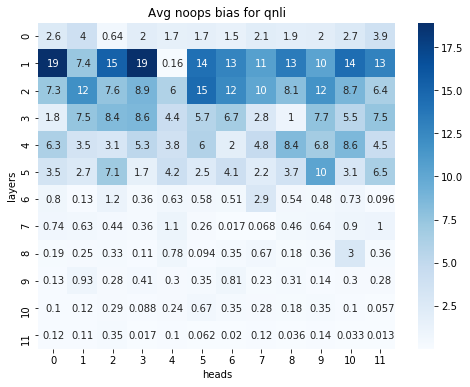

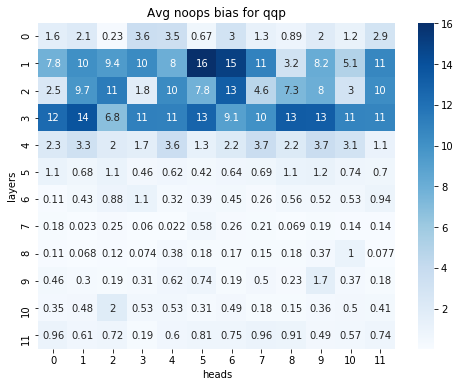

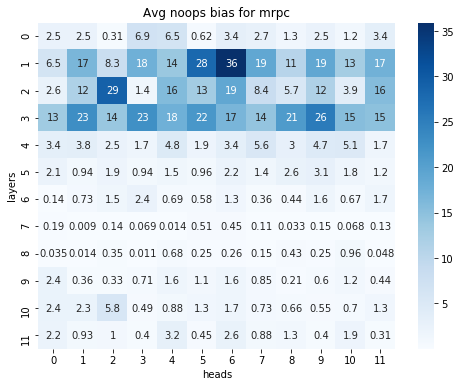

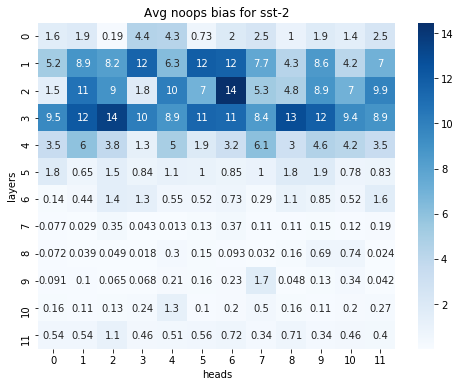

In [9]:
# Driver cell
for task_name in  ['qnli', 'qqp', 'mrpc', 'sst-2']:
    %reset_selective -f "^a$"
    max_seq_len=128
    output_dir = "./sieve_scores/delimiter/"
    tokenizer = tokenization.FullTokenizer(vocab_file="vocab.txt", do_lower_case=True)

    f1, a = init(task_name)
    # No-op heads 
    noops_score = calc_noops_attn_score(a, f1, tokenizer, task_name)
    vis_and_save(noops_score, task_name, output_dir)